In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import glob
#中文使用微软雅黑字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

<font size=5>Step1.合并数据<font>

In [22]:
# 0. 定义需要保留的列名
selected_columns = ["地址", "月租金", "租房面积"]

# 1. 读取所有CSV，仅保留指定列
csv_files = glob.glob(r"C:\Users\XUEJY\Desktop\PythonCode\Rent_price\*.csv")
dfs = []
for file in csv_files:
    df = pd.read_csv(file, encoding='utf-8-sig')
    # 筛选指定列（如果列不存在会报错）
    dfs.append(df[selected_columns])  

# 2. 合并并保存
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.to_csv("merged_Renting.csv", index=False, encoding='utf-8-sig')

In [ ]:
selected_columns = ["地址", "单价", "面积"]

# 1. 读取所有CSV，仅保留指定列
csv_files = glob.glob(r"C:\Users\XUEJY\Desktop\PythonCode\*.csv")
dfs = []
for file in csv_files:
    df = pd.read_csv(file, encoding='utf-8-sig')
    # 筛选指定列（如果列不存在会报错）
    dfs.append(df[selected_columns])  

# 2. 合并并保存
merged_df = pd.concat(dfs, ignore_index=True)
merged_df.to_csv("merged_Housing.csv", index=False, encoding='utf-8-sig')

In [24]:
df_ershou = pd.read_csv('merged_Housing.csv', usecols=['地址', '单价', '面积'])
df_zufang = pd.read_csv('merged_Renting.csv', usecols=['地址', '月租金', '租房面积'])

# 添加序号列（按区域分组生成序号）
df_ershou['序号'] = df_ershou.groupby('地址').cumcount() + 1
df_zufang['序号'] = df_zufang.groupby('地址').cumcount() + 1

# 横向合并（外连接保留所有数据）
merged_df = pd.merge(
    df_ershou,
    df_zufang,
    left_on=['地址', '序号'],
    right_on=['地址', '序号'],
    how='outer',
    suffixes=('_二手房', '_租房')
)

# 调整列顺序（与你的表格一致）
merged_df = merged_df[['地址', '面积', '单价', '地址', '租房面积', '月租金']]

merged_df.to_csv("Merged_Data.csv", index=False, encoding="utf_8_sig")

print("合并后的数据格式：")
print(merged_df.head(5))

合并后的数据格式：
   地址     面积         单价  地址 租房面积   月租金
0  大厂   85.0  \n7505元/㎡  大厂   89   900
1  大厂   88.0    8977元/㎡  大厂   79  1400
2  大厂  100.0    9000元/㎡  大厂   92   500
3  大厂   80.0    8000元/㎡  大厂   78  1400
4  大厂   89.0    7865元/㎡  大厂   89  1500


<font size=5>Step2.数据格式统一 <font>

In [48]:
df = pd.read_csv('Merged_Data.csv', encoding='utf-8-sig')

# 重命名列
df = df.rename(columns={
    '地址': 'area',
    '单价': 'House_price',
    '面积': 'House_area',
    '月租金': 'Rent_price',
    '租房面积': 'Rent_area'
})

# 提取数值部分并转换为浮点数
df['House_area'] = df['House_area'].str.extract(r'(\d+\.?\d*)').astype(float)
df['House_price'] = df['House_price'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Rent_price'] = df['Rent_price'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Rent_area'] = df['Rent_area'].str.extract(r'(\d+\.?\d*)').astype(float)

# 过滤无效数据（面积或租金为0或空）
df = df.dropna(subset=['House_price', 'Rent_price', 'Rent_area', 'area'])
df = df[(df['Rent_price'] > 0) & (df['Rent_area'] > 0)]

# 计算单位租金
df['rent_per_sqm'] = df['Rent_price'] / df['Rent_area']

# 保存修改后的 DataFrame 到新 CSV 文件,注意编码一致，否则经尝试会出现乱码
df.to_csv("Merged_Data.csv", index=False, encoding="utf-8_sig")

<font size=5> Step3.描述性统计 <font>

===== 整体数据的描述性统计 =====
       House_area  House_price  Rent_area  Rent_price  rent_per_sqm
count     734.000      734.000    734.000      734.00       734.000
mean       88.030    12230.150     94.430     2059.58        24.760
std        50.260     8636.770    119.370     1030.43        11.220
min        25.000     4112.000     15.000      300.00         1.000
1%         33.240     4860.530     27.990      900.00         7.220
5%         42.110     5919.600     41.650     1200.00        14.610
25%        68.250     8252.000     75.000     1499.00        18.460
50%        86.850     9816.500     87.000     1800.00        22.000
75%        96.000    12107.250     96.000     2200.00        26.720
95%       134.000    32999.500    130.000     4000.00        50.560
99%       211.230    42104.340    159.690     6000.00        65.960
max      1016.230   113163.000   1900.000     9000.00       100.000
cv          0.571        0.706      1.264        0.50         0.453

===== 整体数据的异常值分析报告 =====

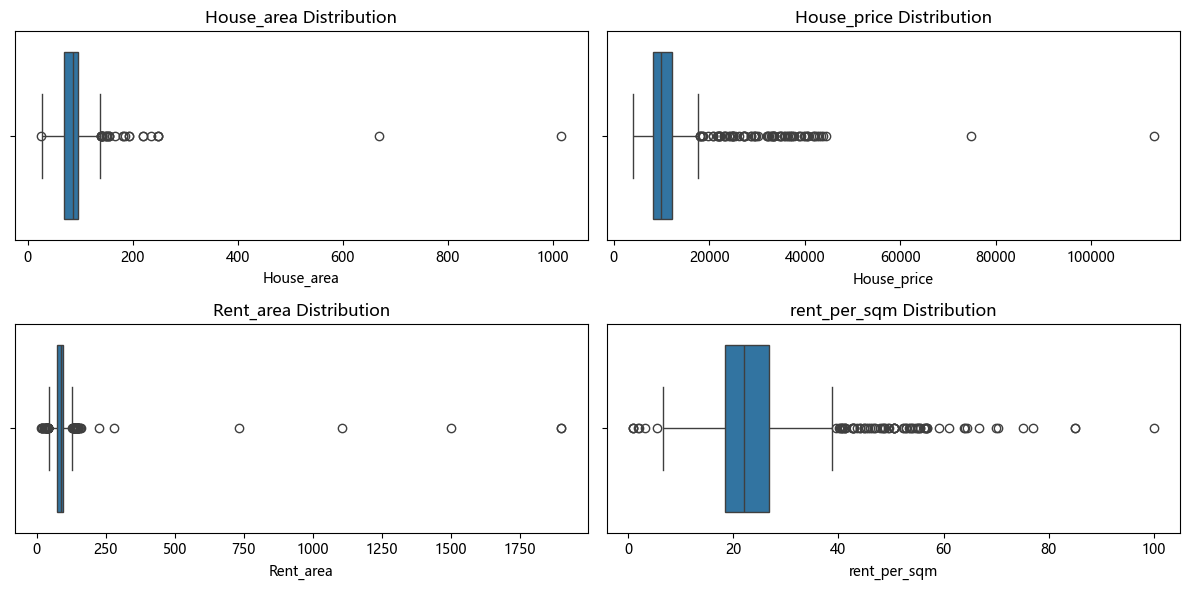

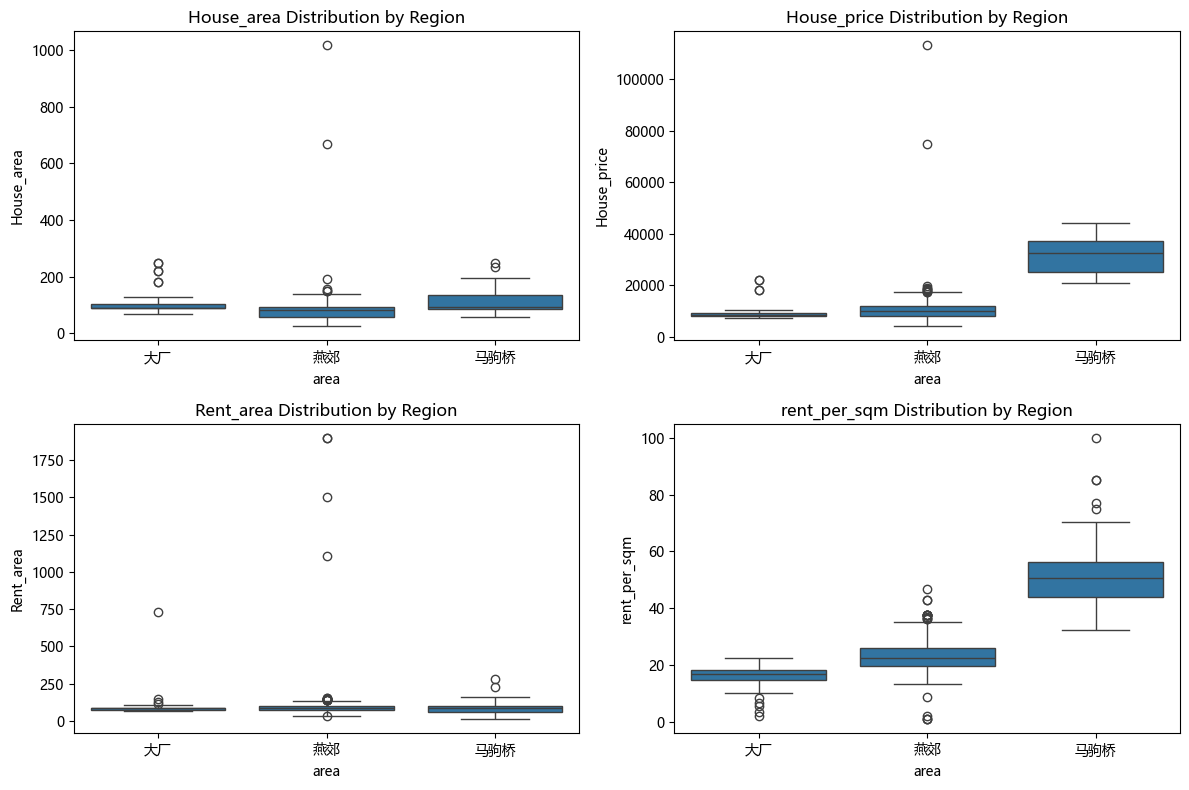

In [50]:
# 描述性统计（整体数据）
description = df[['House_area', 'House_price', 'Rent_area', 'Rent_price','rent_per_sqm']].describe(
    percentiles=[.01, .05, .25, .5, .75, .95, .99]
).round(2)

# 计算变异系数（标准差/均值）
cv = df.std(numeric_only=True) / df.mean(numeric_only=True)
description.loc['cv'] = cv.round(3)

# 异常值检测函数
def detect_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = series[(series < lower) | (series > upper)]
    return {
        'outliers_count': len(outliers),
        'outliers_pct': f"{len(outliers)/len(series)*100:.1f}%",
        'min_val': series.min(),
        'max_val': series.max(),
        'iqr_range': f"{q1:.1f} - {q3:.1f}",
        'outliers_range': f"{lower:.1f} ~ {upper:.1f}"
    }

# 计算整体异常值报告
outliers_report = pd.DataFrame([
    detect_outliers(df['House_area']),
    detect_outliers(df['House_price']),
    detect_outliers(df['Rent_area']),
    detect_outliers(df['rent_per_sqm'])
], index=['House_area', 'House_price', 'Rent_area','rent_per_sqm'])

# 按地区进行分组的描述性统计
grouped_description = df.groupby('area')[['House_area', 'House_price', 'Rent_area','rent_per_sqm']].describe(
    percentiles=[.01, .05, .25, .5, .75, .95, .99]
).round(2)

# 按地区计算变异系数
cv_grouped = df.groupby('area').std(numeric_only=True) / df.groupby('area').mean(numeric_only=True)
cv_grouped = cv_grouped.round(3)

# 按地区计算异常值
outliers_by_region = {}
for region, group in df.groupby('area'):
    outliers_by_region[region] = {
        'House_area': detect_outliers(group['House_area']),
        'House_price': detect_outliers(group['House_price']),
        'Rent_area': detect_outliers(group['Rent_area']),
        'rent_per_sqm': detect_outliers(group['rent_per_sqm'])
    }
outliers_by_region_df = pd.DataFrame(outliers_by_region).T

# 打印整体结果
print("===== 整体数据的描述性统计 =====")
print(description)
print("\n===== 整体数据的异常值分析报告 =====")
print(outliers_report)

print("\n===== 按地区分组的描述性统计 =====")
print(grouped_description)

print("\n===== 按地区分组的变异系数（CV） =====")
print(cv_grouped)

print("\n===== 按地区分组的异常值分析报告 =====")
print(outliers_by_region_df)

# 可视化分布
plt.figure(figsize=(12, 6))
for i, col in enumerate(['House_area', 'House_price', 'Rent_area', 'rent_per_sqm'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i, col in enumerate(['House_area', 'House_price', 'Rent_area', 'rent_per_sqm'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='area', y=col, data=df)
    plt.title(f'{col} Distribution by Region')
plt.tight_layout()
plt.show()

<font size=5> Step4.房价租金比中位数 <font>

area
大厂     512.359203
燕郊     434.755920
马驹桥    618.347519
Name: price_rent_ratio, dtype: float64


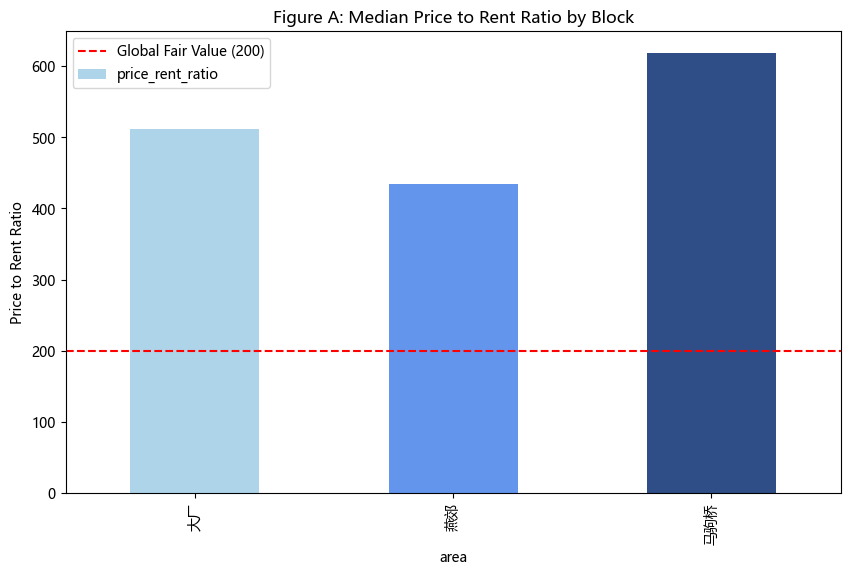

In [6]:
df = pd.read_csv('Merged_Data.csv', encoding='utf-8-sig')
# 计算房价租金比
df['price_rent_ratio'] = df['House_price'] / df['rent_per_sqm']

# 按街区计算中位数
median_ratios = df.groupby('area')['price_rent_ratio'].median()
print(median_ratios)

# 绘制柱状图
plt.figure(figsize=(10, 6))
median_ratios.plot(kind='bar', color=['#aed4e9','cornflowerblue','#2f4e87'])
plt.axhline(y=200, color='red', linestyle='--', label='Global Fair Value (200)')
plt.title('Figure A: Median Price to Rent Ratio by Block')
plt.ylabel('Price to Rent Ratio')
plt.legend()
plt.show()

<font size="3">由输出结果可知，大厂、燕郊及马驹桥地区的房价租金比均显著高于200（全球公平值），意味着房价过高/租金过低，买房者的投资回报率非常低，通过租金需要30年以上才能收回成本；房地产价格可能处于泡沫，租房市场不活跃。该现象一定程度上与国内安土重迁的观念有关。</font>  

<font size=5> Step5.建模预测 <font>

In [22]:
df['area'] = pd.Categorical(df['area'], categories=['燕郊', '大厂', '马驹桥'])

# 生成哑变量，并确保 drop_first=True，避免多重共线性
area_dummies = pd.get_dummies(df['area'], prefix='area', dtype=int, drop_first=True)

# 验证数据类型
print(area_dummies.dtypes)

area_大厂     int32
area_马驹桥    int32
dtype: object


In [24]:
# 先检查 df 是否已有相同列名，避免重复
existing_cols = set(df.columns)
area_dummies = area_dummies.loc[:, ~area_dummies.columns.isin(existing_cols)]

# 连接数据
df = pd.concat([df, area_dummies], axis=1)

# 只遍历非基准类别（从 area_dummies 里取列名，而不是 df['area'].unique()）
for area in area_dummies.columns:  # 遍历已经存在的哑变量列
    area_name = area.replace("area_", "")  # 去掉前缀，得到区域名
    df[f'interaction_house_{area_name}'] = df['House_area'] * df[area]
    df[f'interaction_rent_{area_name}'] = df['Rent_area'] * df[area]

# 打印检查
print(df.head())

  area  House_area  House_price area.1  Rent_area  Rent_price  rent_per_sqm  \
0   大厂        85.0       7505.0     大厂       89.0       900.0     10.112360   
1   大厂        88.0       8977.0     大厂       79.0      1400.0     17.721519   
2   大厂       100.0       9000.0     大厂       92.0       500.0      5.434783   
3   大厂        80.0       8000.0     大厂       78.0      1400.0     17.948718   
4   大厂        89.0       7865.0     大厂       89.0      1500.0     16.853933   

   price_rent_ratio  area_大厂  area_马驹桥  interaction_house_大厂  \
0        742.161111        1         0                  85.0   
1        506.559286        1         0                  88.0   
2       1656.000000        1         0                 100.0   
3        445.714286        1         0                  80.0   
4        466.656667        1         0                  89.0   

   interaction_rent_大厂  interaction_house_马驹桥  interaction_rent_马驹桥  
0                 89.0                    0.0                   0.0  


In [10]:
#使用燕郊作为基准
X_house = df[[
    'House_area', 
    'area_大厂', 
    'area_马驹桥',
    'interaction_house_大厂',
    'interaction_house_马驹桥'
]]

y_house = df['House_price']

# 添加常数项
X_house = sm.add_constant(X_house)

# 建模
house_model = sm.OLS(y_house, X_house).fit()
print(house_model.summary())

                            OLS Regression Results                            
Dep. Variable:            House_price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     682.2
Date:                Thu, 20 Mar 2025   Prob (F-statistic):          7.33e-272
Time:                        10:43:22   Log-Likelihood:                -7056.0
No. Observations:                 734   AIC:                         1.412e+04
Df Residuals:                     728   BIC:                         1.415e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2690.61

In [12]:
# 生成预测数据框架（自动处理交互项和虚拟变量）
def prepare_prediction_data(areas, regions):
    """
    参数：
    areas: list，需要预测的面积列表，如 [50, 100]
    regions: list，需要预测的区域列表，如 ['燕郊', '大厂', '马驹桥']
    
    返回：
    包含所有组合的DataFrame，格式与模型训练数据一致
    """
    # 生成所有面积与区域的组合
    combinations = [(area, region) for area in areas for region in regions]
    
    # 构建数据框架
    data = []
    for area, region in combinations:
        row = {
            'House_area': area,
            'area_大厂': 1 if region == '大厂' else 0,
            'area_马驹桥': 1 if region == '马驹桥' else 0
        }
        # 自动计算交互项
        row['interaction_house_大厂'] = row['House_area'] * row['area_大厂']
        row['interaction_house_马驹桥'] = row['House_area'] * row['area_马驹桥']
        data.append(row)
    
    return pd.DataFrame(data)

# 生成预测数据（50和100平米，3个区域）
pred_data = prepare_prediction_data(
    areas=[50, 100],
    regions=['燕郊', '大厂', '马驹桥']
)

# 添加常数项
pred_data = sm.add_constant(pred_data, has_constant='add')

# 确保列顺序与模型一致
model_features = house_model.params.index.tolist()
pred_data = pred_data[model_features]

# 执行预测
predictions = house_model.predict(pred_data)

# 整理预测结果
result_df = pd.DataFrame({
    '区域': [r for _ in [50,100] for r in ['燕郊','大厂','马驹桥']],
    '面积(㎡)': [50]*3 + [100]*3,
    '预测房屋单价(元/㎡)': predictions.round(1),
})

print("自动生成的预测结果：")
print(result_df.to_string(index=False))

自动生成的预测结果：
 区域  面积(㎡)  预测房屋单价(元/㎡)
 燕郊     50       7304.0
 大厂     50       7913.6
马驹桥     50      30580.4
 燕郊    100      11917.4
 大厂    100       8903.3
马驹桥    100      31863.4


In [14]:
X_rent = df[[
    'Rent_area',
    'area_大厂',
    'area_马驹桥',
    'interaction_rent_大厂',
    'interaction_rent_马驹桥'
]]

y_rent = df['rent_per_sqm']

# 添加常数项
X_rent = sm.add_constant(X_rent)

# 建模
rent_model = sm.OLS(y_rent, X_rent).fit()
print(rent_model.summary())

                            OLS Regression Results                            
Dep. Variable:           rent_per_sqm   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     530.8
Date:                Thu, 20 Mar 2025   Prob (F-statistic):          5.72e-240
Time:                        10:45:08   Log-Likelihood:                -2252.1
No. Observations:                 734   AIC:                             4516.
Df Residuals:                     728   BIC:                             4544.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   24.5021 

In [16]:
# 生成预测数据框架（自动处理交互项和虚拟变量）
def prediction_data(areas, regions):
    """
    参数：
    areas: list，需要预测的面积列表，如 [50, 100]
    regions: list，需要预测的区域列表，如 ['燕郊', '大厂', '马驹桥']
    
    返回：
    包含所有组合的DataFrame，格式与模型训练数据一致
    """
    # 生成所有面积与区域的组合
    combinations = [(area, region) for area in areas for region in regions]
    
    # 构建数据框架
    dataR = []
    for area, region in combinations:
        row = {
            'Rent_area': area,
            'area_大厂': 1 if region == '大厂' else 0,
            'area_马驹桥': 1 if region == '马驹桥' else 0
        }
        # 自动计算交互项
        row['interaction_rent_大厂'] = row['Rent_area'] * row['area_大厂']
        row['interaction_rent_马驹桥'] = row['Rent_area'] * row['area_马驹桥']
        dataR.append(row)
    
    return pd.DataFrame(dataR)

# 生成预测数据（50和100平米，3个区域）
pred_data = prediction_data(
    areas=[50, 100],
    regions=['燕郊', '大厂', '马驹桥']
)

# 添加常数项
pred_data = sm.add_constant(pred_data, has_constant='add')

# 确保列顺序与模型一致
model_features = rent_model.params.index.tolist()
pred_data = pred_data[model_features]

# 执行预测
predictions = rent_model.predict(pred_data)

# 整理预测结果
result_Rdf = pd.DataFrame({
    '区域': [r for _ in [50,100] for r in ['燕郊','大厂','马驹桥']],
    '面积(㎡)': [50]*3 + [100]*3,
    '预测租金单价(元/㎡)': predictions.round(1),
})

print("自动生成的预测结果：")
print(result_Rdf.to_string(index=False))

自动生成的预测结果：
 区域  面积(㎡)  预测租金单价(元/㎡)
 燕郊     50         23.7
 大厂     50         17.0
马驹桥     50         58.5
 燕郊    100         23.0
 大厂    100         15.9
马驹桥    100         49.5


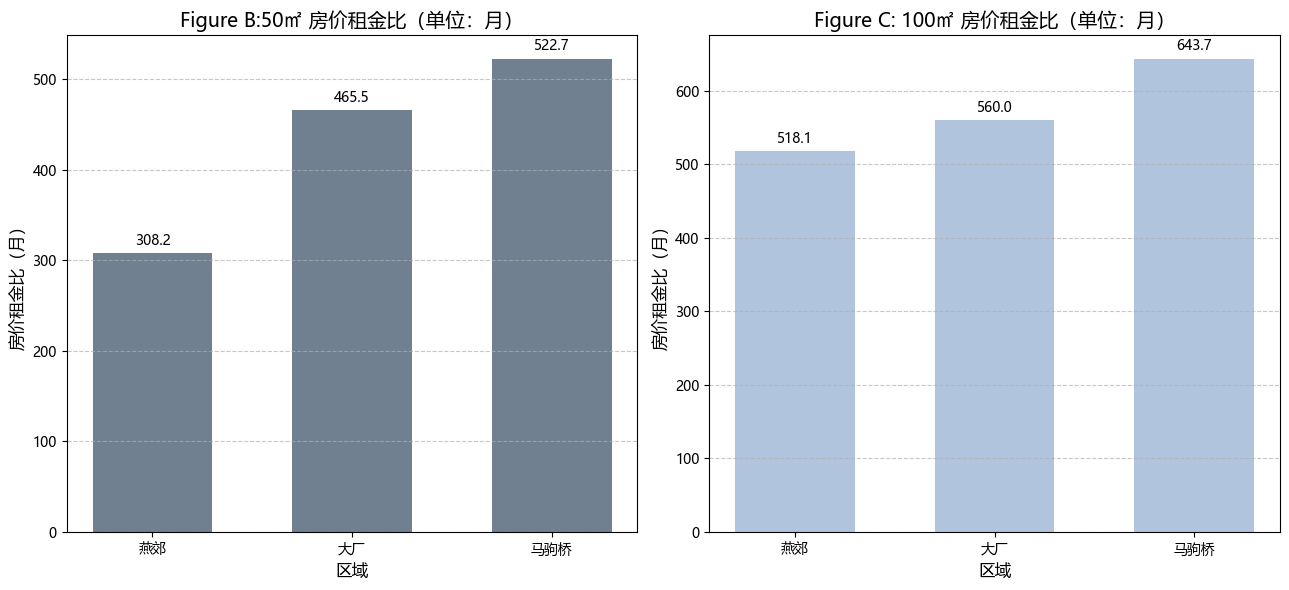

In [20]:
# 计算房价租金比（月）
result_df['房价租金比（月）'] = result_df['预测房屋单价(元/㎡)'] / result_Rdf['预测租金单价(元/㎡)']

# 获取区域和面积分类
regions = result_df['区域'].unique()
x = np.arange(len(regions))  # 3个区域

# 获取50㎡和100㎡的PRR
prr_50 = result_df[result_df['面积(㎡)'] == 50]['房价租金比（月）']
prr_100 = result_df[result_df['面积(㎡)'] == 100]['房价租金比（月）']

# 创建两个子图
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

max_prr = max(prr_50.max(), prr_100.max())
ylim_upper = max_prr * 1.2 

# 50㎡ 的图表
axes[0].bar(x, prr_50, color='slategrey', width=0.6)
axes[0].set_title('Figure B:50㎡ 房价租金比（单位：月）', fontsize=14)
axes[0].set_xlabel('区域', fontsize=12)
axes[0].set_ylabel('房价租金比（月）', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(regions)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 100㎡ 的图表
axes[1].bar(x, prr_100, color='lightsteelblue', width=0.6)
axes[1].set_title('Figure C: 100㎡ 房价租金比（单位：月）', fontsize=14)
axes[1].set_xlabel('区域', fontsize=12)
axes[1].set_ylabel('房价租金比（月）', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels(regions)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 添加数值标签
def autolabel(ax, rects):
    """ 给柱子添加数据标签 """
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# 添加数据标签
rects_50 = axes[0].bar(x, prr_50, color='slategrey', width=0.6)
rects_100 = axes[1].bar(x, prr_100, color='lightsteelblue', width=0.6)

autolabel(axes[0], rects_50)
autolabel(axes[1], rects_100)

# 调整布局
plt.tight_layout()
plt.show()